# Final Submission: Image Classification Model Deployment
Vian Sebastian Bromokusumo

> username: vianvian


> email: viansebastianbromokusumo@mail.ugm.ac.id


In [ ]:
# Criteria:
# 1. Dataset min 10.000 images                <----->
# 2. Dataset is never used before             <----->
# 3. 20% test set                             <----->
# 4. Sequential                               <----->
# 5. Model EXPLICITLY  uses Conv2D Max Pooling Layer      <----->
# 6. Accuracy min. 92%                        <----->
# 7. Plot training, validation and loss       <----->
# 8. Save in TFLite                           <----->
# 9. Images must have various resolutions     <----->
# 10. Min. classes = 3                        <----->

In [ ]:
!nvidia-smi

Thu Jan 25 11:47:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0              34W /  70W |   8319MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
# import general dependencies
import tensorflow as tf
from tensorflow.keras.layers import Input
import numpy as np
import matplotlib.pyplot as plt
import pathlib

In [ ]:
# checking files
import os

base_dir = '/content/drive/MyDrive/Colab Notebooks/Dicoding Machine Learning Intermediate/archive/raw-img'
os.listdir(base_dir)

['elefante',
 'cane',
 'pecora',
 'scoiattolo',
 'gatto',
 'mucca',
 'cavallo',
 'gallina',
 'ragno',
 'farfalla']

Image shape for elefante: (300, 225)
Image shape for cane: (300, 225)
Image shape for pecora: (300, 237)
Image shape for scoiattolo: (247, 300)
Image shape for gatto: (201, 300)
Image shape for mucca: (300, 225)
Image shape for cavallo: (300, 225)
Image shape for gallina: (300, 224)
Image shape for ragno: (300, 283)
Image shape for farfalla: (300, 225)
(300, 225)


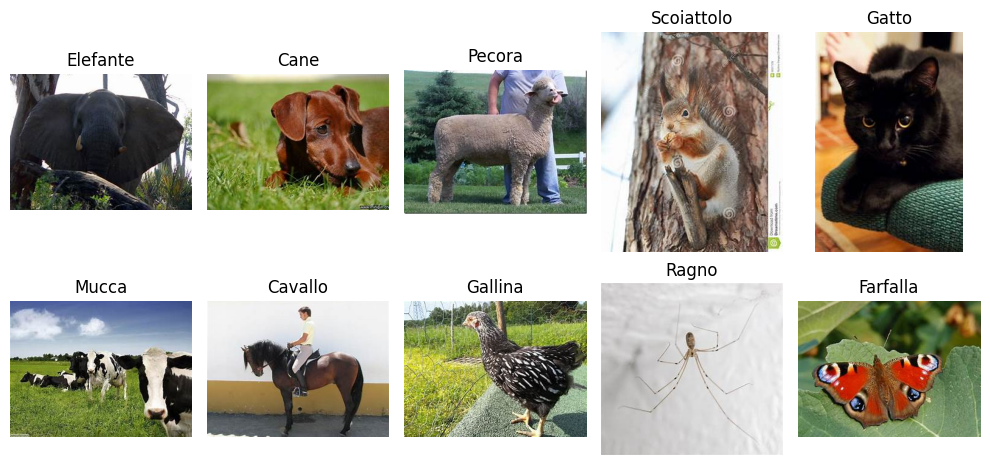

In [ ]:
# showing dataset's images
from PIL import Image

subdirectories = ['elefante', 'cane', 'pecora', 'scoiattolo', 'gatto', 'mucca', 'cavallo', 'gallina', 'ragno', 'farfalla']

fig, axs = plt.subplots(2, 5, figsize=(10, 5))

axs = axs.flatten()


for i, subdirectory in enumerate(subdirectories):

    files = os.listdir(os.path.join(base_dir, subdirectory))

    image_path = os.path.join(base_dir, subdirectory, files[0])

    img = Image.open(image_path)
    axs[i].imshow(img)
    axs[i].axis('off')
    axs[i].set_title(subdirectory.capitalize())
    print(f"Image shape for {subdirectory}: {img.size}")

print(img.size)
plt.tight_layout()
plt.show()

count elefante: 1446
count cane: 4864
count pecora: 1820
count scoiattolo: 1862
count gatto: 1668
count mucca: 1866
count cavallo: 2623
count gallina: 3098
count ragno: 4821
count farfalla: 2112


<ipython-input-174-e1fe4c409f40>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Count', y='Label', data=df_counts, alpha=0.8, palette='pastel')


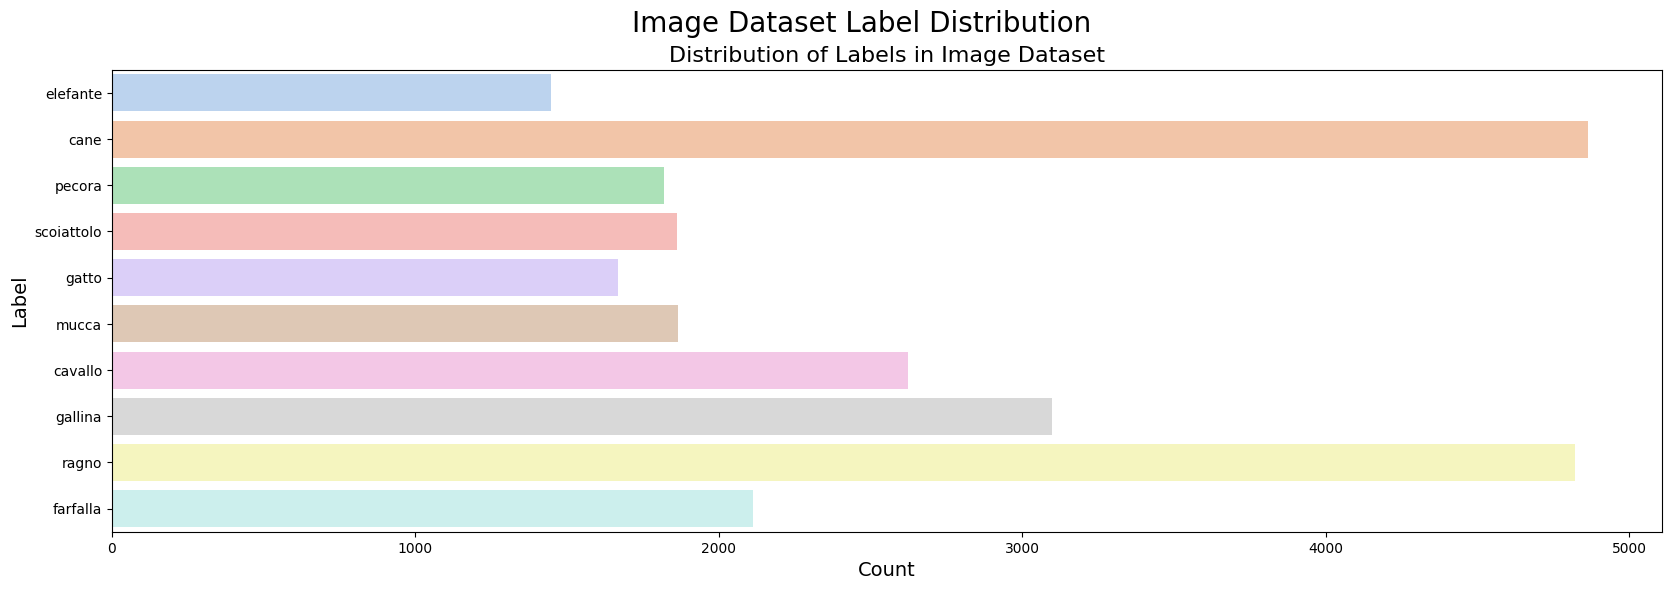

In [ ]:
# showing dataset's distribution
import pandas as pd
import seaborn as sns

subdirectories = ['elefante', 'cane', 'pecora', 'scoiattolo', 'gatto', 'mucca', 'cavallo', 'gallina', 'ragno', 'farfalla']
counts = {}


for i, subdirectory in enumerate(subdirectories):

    files = os.listdir(os.path.join(base_dir, subdirectory))
    counts[subdirectory] = len(files)
    print(f"count {subdirectory}: {counts[subdirectory]}")

df_counts = pd.DataFrame(list(counts.items()), columns=['Label', 'Count'])

plt.figure(figsize=(20, 6))
sns.barplot(x='Count', y='Label', data=df_counts, alpha=0.8, palette='pastel')
plt.title('Distribution of Labels in Image Dataset', fontsize=16)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Label', fontsize=14)
plt.suptitle('Image Dataset Label Distribution', fontsize=20)

plt.show()

In [ ]:
# image augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    base_dir,
    target_size = (224,224),
    batch_size = 128,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'training'
)

val_generator = val_datagen.flow_from_directory(
    base_dir,
    target_size = (224,224),
    batch_size = 128,
    class_mode = 'categorical',
    shuffle = True,
    subset = 'validation'
)

Found 20948 images belonging to 10 classes.
Found 5232 images belonging to 10 classes.


In [ ]:
# InceptionV3 Model
from tensorflow.keras.applications import InceptionV3

# load InceptionV3 Model
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

for layer in base_model.layers:
    layer.trainable = False

# last_output = base_model.output

In [ ]:
# InceptionV3 Model Architecture
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_965 (Conv2D)         (None, 111, 111, 32)         864       ['input_11[0][0]']            
                                                                                                  
 batch_normalization_941 (B  (None, 111, 111, 32)         96        ['conv2d_965[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_940 (Activation  (None, 111, 111, 32)         0         ['batch_normalizati

InceptionV3 memiliki lima convolutional layers, dua max-pooling layers,sebelas inception modules, satu average pooling layer, dan satu fully connected layer.

In [ ]:
# model's architecture
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization

model = tf.keras.models.Sequential([
    base_model,
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    MaxPooling2D((2,2)),
    GlobalAveragePooling2D(),
    Dense(1024, activation = 'relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(512, activation = 'relu'),
    Dense(10, activation='softmax')
])

model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 conv2d_1059 (Conv2D)        (None, 5, 5, 64)          1179712   
                                                                 
 max_pooling2d_69 (MaxPooli  (None, 2, 2, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_1060 (Conv2D)        (None, 2, 2, 128)         73856     
                                                                 
 max_pooling2d_70 (MaxPooli  (None, 1, 1, 128)         0         
 ng2D)                                                           
                                                                 
 global_average_pooling2d_1  (None, 128)             

In [ ]:
# implementing callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler

checkpoint_path = "model_checkpoint.h5"
checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    mode = 'max',
    verbose = 1
)

lr_reduction = ReduceLROnPlateau(
    monitor = 'accuracy',
    patience = 3,
    verbose = 1,
    factor = 0.1,
    min_lr = 0.000001
)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    acc = logs.get('accuracy')
    val_acc = logs.get('val_accuracy')

    if(acc > 0.92 and val_acc > 0.92):
      print("\nReached wanted accuracy so cancelling training!")
      self.model.stop_training = True

earlyStop = myCallback()

In [ ]:
# compiling the model
model.compile(
    loss ='categorical_crossentropy',
    optimizer = tf.optimizers.Adam(learning_rate = 0.001),
    metrics = ['accuracy']
)

In [ ]:
# configure steps for train and val per epoch
train_steps = round(20948/128)
val_steps = round(5232/128)

print(train_steps)
print(val_steps)

164
41


In [ ]:
# training the model
hist = model.fit(
    train_generator,
    steps_per_epoch = train_steps,
    epochs = 100,
    validation_data = val_generator,
    validation_steps = val_steps,
    verbose = 1,
    callbacks = [lr_reduction, earlyStop, checkpoint]
)

Epoch 1/100
164/164 [==============================] - ETA: 0s - loss: 0.6305 - accuracy: 0.7907
Epoch 1: accuracy improved from -inf to 0.79072, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


164/164 [==============================] - 370s 2s/step - loss: 0.6305 - accuracy: 0.7907 - val_loss: 0.2045 - val_accuracy: 0.9386 - lr: 0.0010
Epoch 2/100
164/164 [==============================] - ETA: 0s - loss: 0.4694 - accuracy: 0.8463
Epoch 2: accuracy improved from 0.79072 to 0.84629, saving model to model_checkpoint.h5
164/164 [==============================] - 348s 2s/step - loss: 0.4694 - accuracy: 0.8463 - val_loss: 0.2206 - val_accuracy: 0.9344 - lr: 0.0010
Epoch 3/100
164/164 [==============================] - ETA: 0s - loss: 0.4308 - accuracy: 0.8572
Epoch 3: accuracy improved from 0.84629 to 0.85717, saving model to model_checkpoint.h5
164/164 [==============================] - 364s 2s/step - loss: 0.4308 - accuracy: 0.8572 - val_loss: 0.1855 - val_accuracy: 0.9446 - lr: 0.0010
Epoch 4/100
164/164 [==============================] - ETA: 0s - loss: 0.3964 - accuracy: 0.8703
Epoch 4: accuracy improved from 0.85717 to 0.87025, saving model to model_checkpoint.h5
164/164 [=

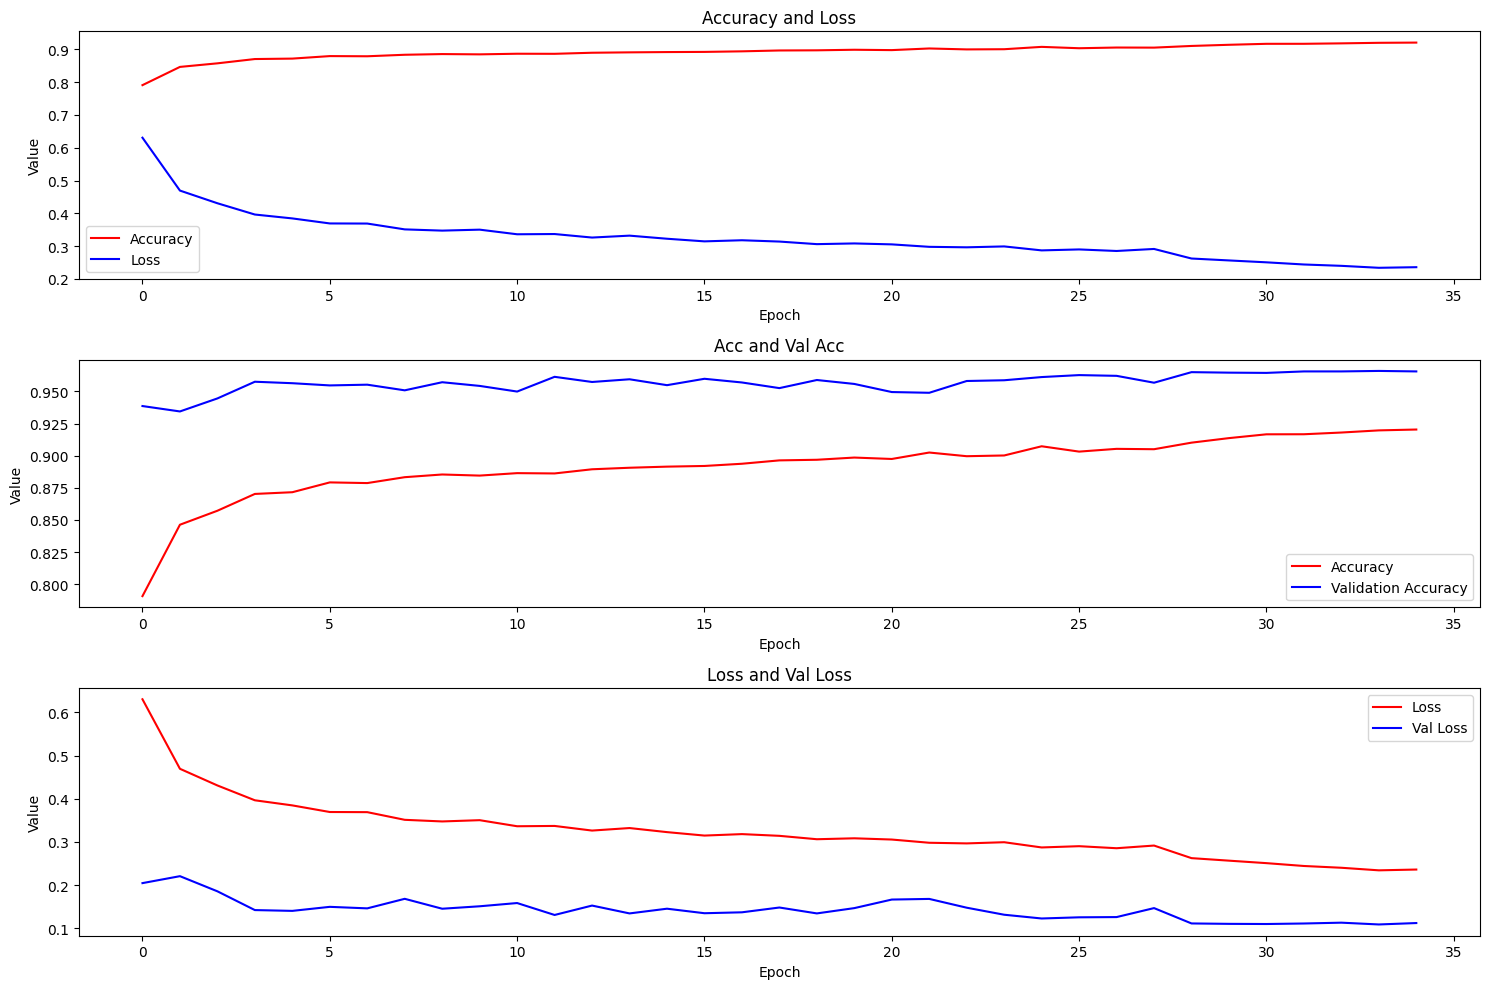

In [ ]:
# plotting accuracy and loss
accuracy = hist.history['accuracy']
validation_accuracy = hist.history['val_accuracy']
loss = hist.history['loss']
validation_loss = hist.history['val_loss']

fig, ax = plt.subplots(nrows = 3, figsize = (15, 10))

ax[0].plot(accuracy, 'r', label='Accuracy')
ax[0].plot(loss, 'b', label='Loss')
ax[0].set_title('Accuracy and Loss')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Value')
ax[0].legend(loc = 0)

ax[1].plot(accuracy, 'r', label='Accuracy')
ax[1].plot(validation_accuracy, 'b', label='Validation Accuracy')
ax[1].set_title('Acc and Val Acc')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Value')
ax[1].legend(loc = 0)

ax[2].plot(loss, 'r', label='Loss')
ax[2].plot(validation_loss, 'b', label='Val Loss')
ax[2].set_title('Loss and Val Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Value')
ax[2].legend(loc = 0)

plt.tight_layout()
plt.show()

In [ ]:
# model deployment and export
export_dir = 'saved_model/'
tf.saved_model.save(model, export_dir)

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
tflite_model = converter.convert()

In [ ]:
tflite_model_file = pathlib.Path('animals-classification.tflite')
tflite_model_file.write_bytes(tflite_model)

94802644